In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


In [2]:
w, b = 2.0, 5.0
n_samples = 100
x = torch.rand(n_samples, 1) #échantillion de taille (100x1)
y = w * x + b + torch.normal(0, 0.1, (n_samples, 1)) 

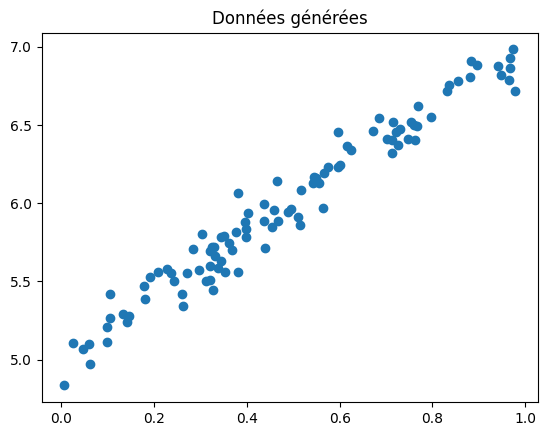

In [3]:
#Visualisation des données
plt.scatter(x, y)
plt.title('Données générées')
plt.show()

In [4]:
indices = np.arange(n_samples)
np.random.shuffle(indices)
train_size = int(0.8 * n_samples)
train_indices, test_indices = indices[:train_size], indices[train_size:]
x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]


In [5]:
model = nn.Linear(1, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(torch.tensor(x_train, dtype=torch.float32))
    loss = criterion(predictions, torch.tensor(y_train, dtype=torch.float32))
    loss.backward()
    optimizer.step()


/tmp/ipykernel_67347/3645849812.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(x_train, dtype=torch.float32))
/tmp/ipykernel_67347/3645849812.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(predictions, torch.tensor(y_train, dtype=torch.float32))


In [6]:
#Créer un jeu de donnée corrompu

alpha = 0.2
n_poisoned = int(alpha * n_samples)
poisoned_indices = np.random.choice(n_samples, n_poisoned, replace=False)
y_poisoned = y.clone()
y_poisoned[poisoned_indices] += torch.normal(0, 1.0, (n_poisoned, 1))


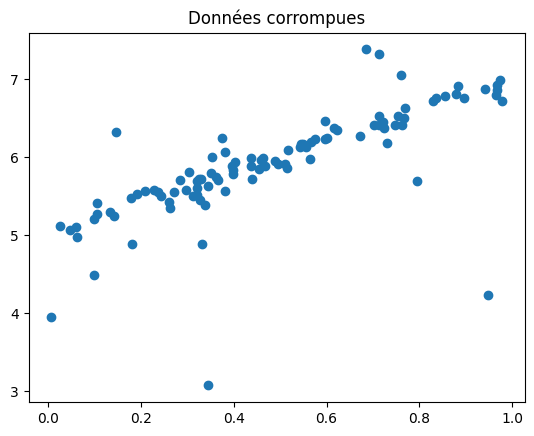

In [7]:
#Visualiser les données corrompues
plt.scatter(x, y_poisoned)
plt.title('Données corrompues')
plt.show()


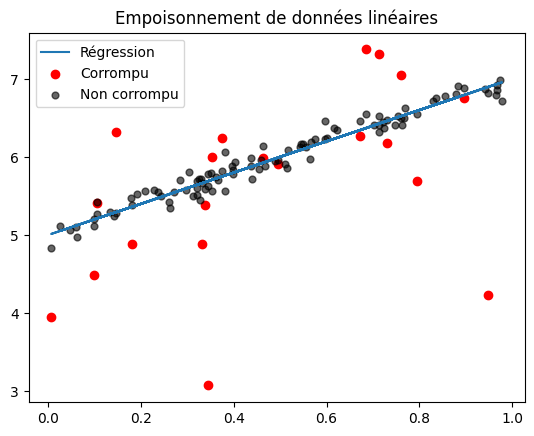

In [8]:
plt.plot(x, w * x + b, label='Régression')
plt.scatter(x[poisoned_indices], y_poisoned[poisoned_indices], label='Corrompu', c='r')
plt.scatter(x, y, label='Non corrompu', c='black', s=24, alpha=0.6)
plt.title('Empoisonnement de données linéaires')
plt.legend()
plt.show()


In [9]:
#Entraîner un modèle sur les données corrompues

x_poisoned, y_poisoned = torch.tensor(x, dtype=torch.float32), torch.tensor(y_poisoned, dtype=torch.float32)
model_corrupted = nn.Linear(1, 1)
optimizer_corrupted = optim.SGD(model_corrupted.parameters(), lr=0.1)

for epoch in range(n_epochs):
    model_corrupted.train()
    optimizer_corrupted.zero_grad()
    predictions_corrupted = model_corrupted(x_poisoned)
    loss_corrupted = criterion(predictions_corrupted, y_poisoned)
    loss_corrupted.backward()
    optimizer_corrupted.step()


/tmp/ipykernel_67347/1479038440.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_poisoned, y_poisoned = torch.tensor(x, dtype=torch.float32), torch.tensor(y_poisoned, dtype=torch.float32)


In [10]:
#Évaluer la précision
model_corrupted.eval()
with torch.no_grad():
    test_predictions_corrupted = model_corrupted(x_test)
    test_loss_corrupted = criterion(test_predictions_corrupted, y_test)
    print(f'Test Loss with corrupted data: {test_loss_corrupted.item()}')


Test Loss with corrupted data: 0.014101291075348854


## Impact de la variance du poison sur la précision du modèle

Nous appliquons l'empoisonnement sur toutes les données.

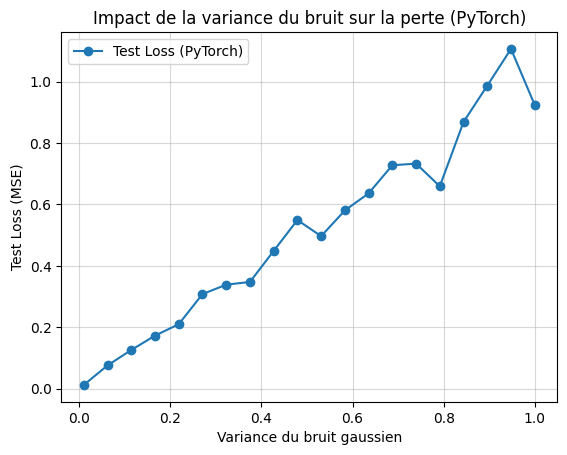

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Définir le modèle de régression linéaire
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # Une entrée, une sortie

    def forward(self, x):
        return self.linear(x)

# Fonction pour générer des données linéaires et bruitées (train/test split inclus)
def generate_data_pytorch(w, b, n_samples, noise_variance, test_ratio=0.2):
    x = torch.rand(n_samples, 1)
    noise = torch.normal(mean=0, std=noise_variance**0.5, size=(n_samples, 1))
    y = w * x + b + noise
    split_idx = int(n_samples * (1 - test_ratio))
    return x[:split_idx], y[:split_idx], x[split_idx:], y[split_idx:]

# Configuration des paramètres
w, b = 2.0, 5.0
n_samples = 2000
noise_variances = torch.linspace(0.01, 1.0, 20)  # Différentes variances de bruit
test_losses = []

# Entraîner et évaluer le modèle pour chaque variance de bruit
for noise_variance in noise_variances:
    # Générer les données
    x_train, y_train, x_test, y_test = generate_data_pytorch(w, b, n_samples, noise_variance.item())

    # Initialiser le modèle, la perte et l'optimiseur
    model = LinearRegressionModel()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # Entraînement du modèle
    epochs = 100
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # Évaluation sur les données de test
    model.eval()
    with torch.no_grad():
        y_test_pred = model(x_test)
        test_loss = criterion(y_test_pred, y_test).item()
    test_losses.append(test_loss)

# Tracer la courbe
plt.plot(noise_variances.numpy(), test_losses, marker='o', label='Test Loss (PyTorch)')
plt.xlabel('Variance du bruit gaussien')
plt.ylabel('Test Loss (MSE)')
plt.title('Impact de la variance du bruit sur la perte (PyTorch)')
plt.grid(alpha=0.5)
plt.legend()
plt.show()